In [ ]:
from google.colab import files
uploaded = files.upload()




Saving crop_yield_2.csv to crop_yield_2.csv
Saving data_core.csv to data_core.csv
Saving crop_yield_1.csv to crop_yield_1.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving crop_yield_2.csv to crop_yield_2.csv
Saving data_core.csv to data_core.csv
Saving crop_yield_1.csv to crop_yield_1.csv


In [ ]:
from google.colab import files
files.download(str(out_path))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# ------------------------------------------------------------------
# Load data
# ------------------------------------------------------------------
DATA_DIR = Path("dataset")
yield1 = pd.read_csv("crop_yield_1.csv")
yield2 = pd.read_csv("crop_yield_2.csv")
core   = pd.read_csv("data_core.csv")

# ------------------------------------------------------------------
# Normalise crop names
# ------------------------------------------------------------------
crop_name_mapping = {
    "Cotton(lint)": "Cotton",
    "Arhar/Tur":    "Pigeon Peas",
    "Gram":         "Chickpea",
}
yield1["Crop"]    = yield1["Crop"].replace(crop_name_mapping)
yield2["Crop"]    = yield2["Crop"].replace(crop_name_mapping)
core["Crop Type"] = core["Crop Type"].replace(crop_name_mapping)

# ------------------------------------------------------------------
# Region mapping (extend whenever you add more states)
# ------------------------------------------------------------------
state_to_region = {
    "Assam":    "East",
    "Punjab":   "North",
    "Kerala":   "South",
    "Rajasthan":"West",
}
yield1["Region"] = yield1["State"].map(state_to_region)

# ------------------------------------------------------------------
# Merge the two yield-related files
# ------------------------------------------------------------------
merged_yield = pd.merge(
    yield2,
    yield1[["Region", "Crop", "Annual_Rainfall", "Season"]],
    on=["Region", "Crop"],
    how="left",
)

# ------------------------------------------------------------------
# Prepare core-agronomy dataframe & merge
# ------------------------------------------------------------------
core_renamed = core.rename(
    columns={
        "Crop Type":   "Crop",
        "Soil Type":   "Soil_Type",
        "Temparature": "Core_Temp",
        "Temperature": "Core_Temp",
        "Humidity":    "Core_Humidity",
    }
)

final_df = pd.merge(
    merged_yield,
    core_renamed,
    on=["Crop", "Soil_Type"],
    how="left",
)

# ------------------------------------------------------------------
# Weather harmonisation
# ------------------------------------------------------------------
final_df["Rainfall_mm"]         = final_df["Rainfall_mm"].fillna(final_df["Annual_Rainfall"])
final_df["Temperature_Celsius"] = final_df["Temperature_Celsius"].fillna(final_df["Core_Temp"])

# Prefer Core Humidity where available; otherwise keep yield-2 value
final_df["Humidity"] = final_df["Core_Humidity"].combine_first(final_df["Humidity"])

# ------------------------------------------------------------------
# Other missing-value handling
# ------------------------------------------------------------------
final_df["Season"]   = final_df["Season"].fillna(final_df["Weather_Condition"])
final_df["Moisture"] = final_df["Moisture"].fillna(final_df["Moisture"].median())
final_df[["Nitrogen", "Potassium", "Phosphorous"]] = (
    final_df[["Nitrogen", "Potassium", "Phosphorous"]].fillna(0)
)

# ------------------------------------------------------------------
# Select & rename the outward-facing columns
# ------------------------------------------------------------------
cols_to_keep = [
    "Region", "Soil_Type", "Crop",
    "Rainfall_mm", "Temperature_Celsius", "Humidity", "Moisture",
    "Nitrogen", "Potassium", "Phosphorous",
    "Fertilizer_Used", "Irrigation_Used",
    "Season", "Fertilizer Name",
]
final_df = final_df[cols_to_keep].rename(
    columns={
        "Fertilizer Name": "Fertilizer_Type",
        "Season":          "Season_or_Weather",
    }
)

# ------------------------------------------------------------------
# De-duplicate and take an *automatic* sample
# ------------------------------------------------------------------
final_df = final_df.drop_duplicates()

max_possible_rows = max(len(yield1), len(yield2), len(core))
sample_size       = min(max_possible_rows, len(final_df))

final_df = final_df.sample(n=sample_size, random_state=42)


out_path = DATA_DIR / "crop_recommendation_dataset.csv"
final_df.to_csv(out_path, index=False)
print(f"Dataset saved ➜ {out_path} with {len(final_df):,} rows")

Dataset saved ➜ dataset/crop_recommendation_dataset.csv with 50,000 rows


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
df = pd.read_csv('dataset/crop_recommendation_dataset.csv')

# Display first few rows
print(df.head())

  Region Soil_Type    Crop  Rainfall_mm  Temperature_Celsius Humidity  \
0  North     Sandy  Cotton   971.312391            35.877945    63.42   
1  South     Sandy  Cotton   600.604348            19.109415    50.54   
2  South     Sandy  Cotton   290.144633            38.582930    70.42   
3  North     Sandy   Wheat   680.118952            21.295254    66.87   
4   East     Sandy  Barley   676.771812            19.422782    58.39   

   Moisture  Nitrogen  Potassium  Phosphorous  Fertilizer_Used  \
0     24.65      13.0        1.0         42.0             True   
1     54.24       8.0        7.0         26.0             True   
2     24.42      19.0        2.0         24.0            False   
3     53.32      11.0       10.0         15.0             True   
4     64.42       8.0        1.0         11.0            False   

   Irrigation_Used Season_or_Weather Fertilizer_Type  
0            False       Kharif             17-17-17  
1             True       Kharif             14-35-14  

In [ ]:
# Data Exploration
print("Shape:", df.shape)
print("Columns:", df.columns)
print("Missing values:\n", df.isnull().sum())
print("Data types:\n", df.dtypes)

Shape: (50000, 14)
Columns: Index(['Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius',
       'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous',
       'Fertilizer_Used', 'Irrigation_Used', 'Season_or_Weather',
       'Fertilizer_Type'],
      dtype='object')
Missing values:
 Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Humidity                  0
Moisture                  0
Nitrogen                  0
Potassium                 0
Phosphorous               0
Fertilizer_Used           0
Irrigation_Used           0
Season_or_Weather         0
Fertilizer_Type        2968
dtype: int64
Data types:
 Region                  object
Soil_Type               object
Crop                    object
Rainfall_mm            float64
Temperature_Celsius    float64
Humidity                object
Moisture               float64
Nitrogen               float64
Potassium              floa

In [ ]:
# Statistical summary
df.describe()

,Rainfall_mm,Temperature_Celsius,Moisture,Nitrogen,Potassium,Phosphorous
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,554.383603,27.623150,43.919961,17.449760,3.369400,17.426620
std,262.079138,7.279345,12.096350,12.040979,5.086989,13.242125
min,100.014436,15.008175,20.000000,0.000000,0.000000,0.000000
25%,328.965055,21.323919,35.000000,9.000000,0.000000,4.000000
50%,549.501168,27.666370,43.280000,13.000000,1.000000,17.000000
75%,786.207865,33.982725,52.820000,25.000000,4.000000,28.000000
max,999.894823,39.997653,70.000000,45.000000,23.000000,46.000000


In [ ]:
# Check for duplicates
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicates: 0


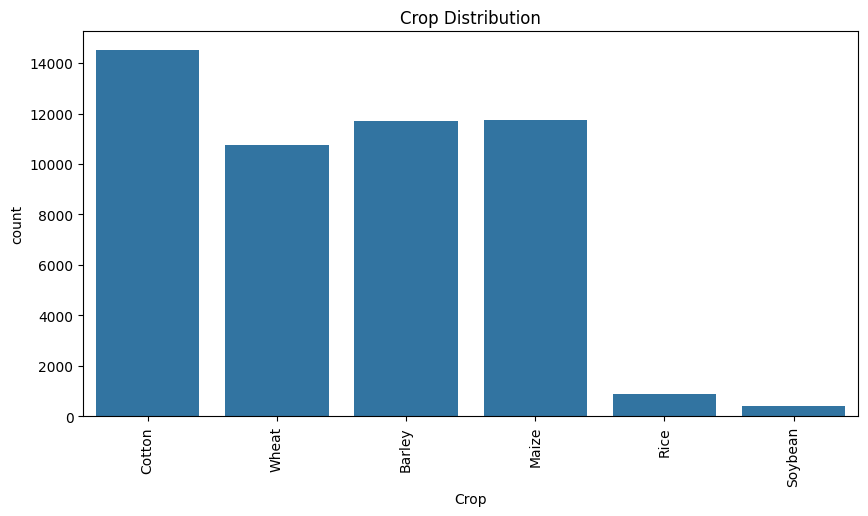

In [ ]:
# Visualize class distribution
plt.figure(figsize=(10,5))
sns.countplot(x='Crop', data=df)
plt.title('Crop Distribution')
plt.xticks(rotation=90)
plt.show()

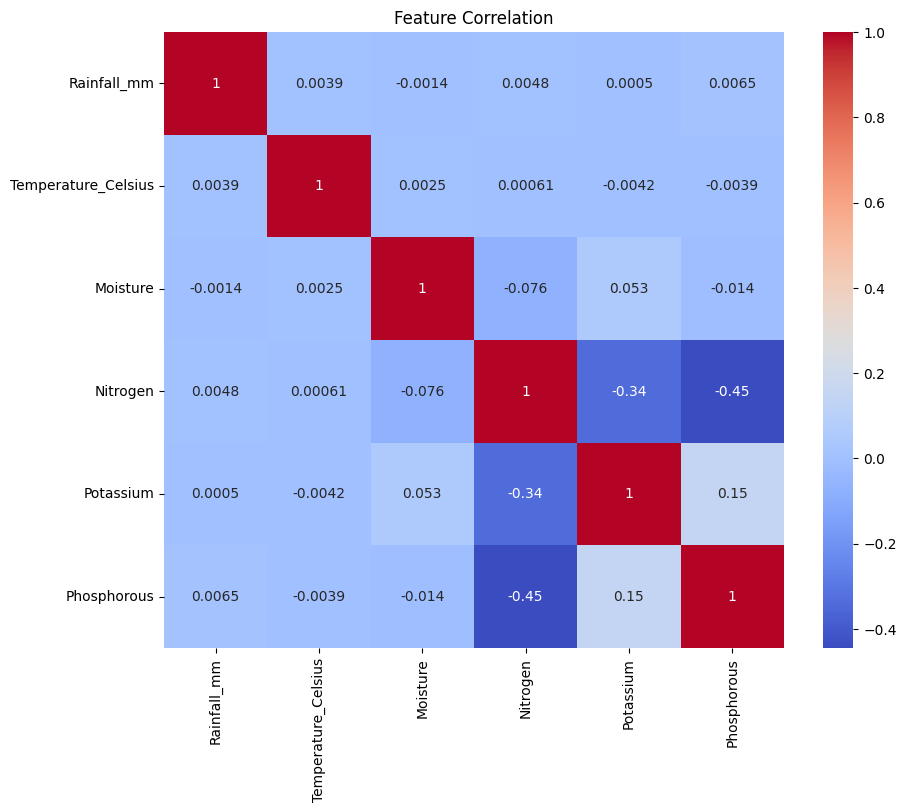

In [ ]:
# Feature correlation (numeric columns only)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

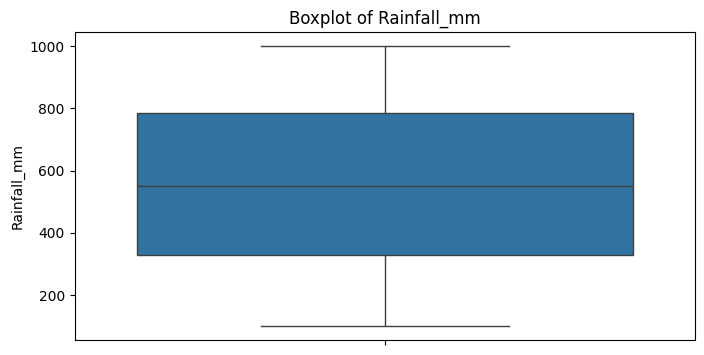

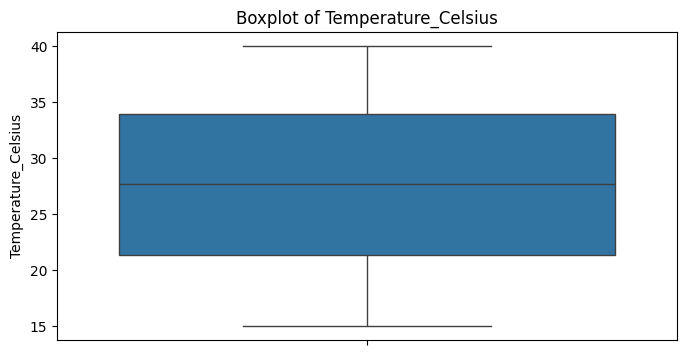

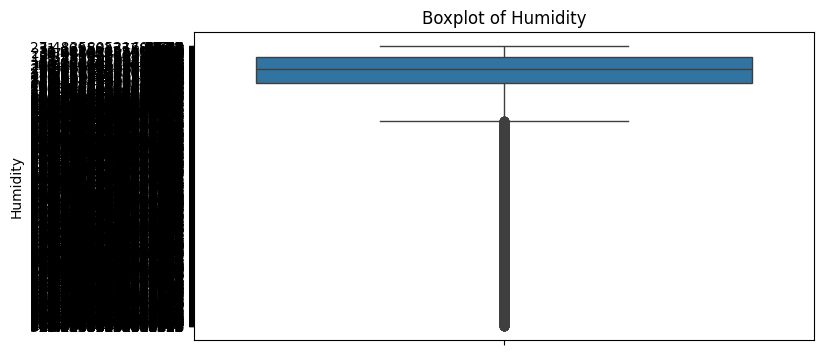

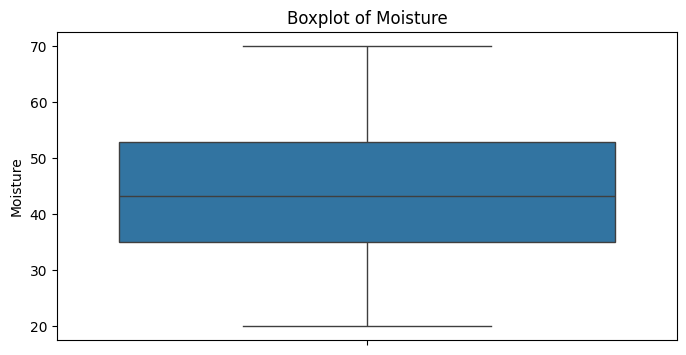

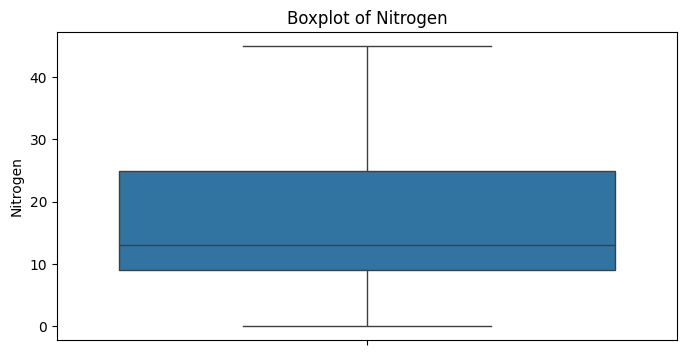

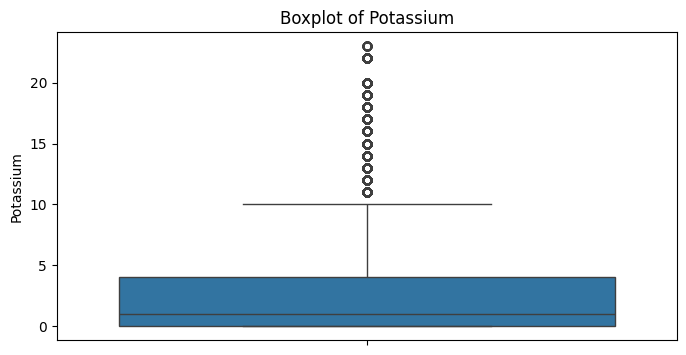

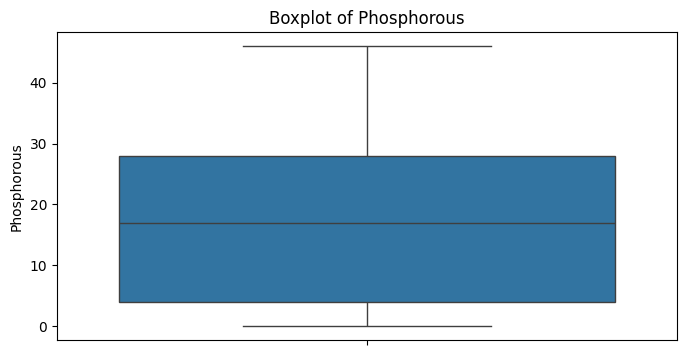

In [ ]:
# Data Cleaning & Transformation

# Check for outliers (numeric columns only)
for col in ['Rainfall_mm', 'Temperature_Celsius', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Remove outliers: Use correct column names
df = df[(df['Nitrogen'] >= 0) & (df['Nitrogen'] <= 140)]
df = df[(df['Phosphorous'] >= 0) & (df['Phosphorous'] <= 145)]
df = df[(df['Potassium'] >= 0) & (df['Potassium'] <= 205)]

In [ ]:
# Encode target variable (use 'Crop' as label)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['Crop'])

In [ ]:
# Split data
from sklearn.model_selection import train_test_split

X = df.drop(['label_enc'], axis=1)
y = df['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Encode categorical features using one-hot encoding
X_encoded = pd.get_dummies(X)

In [ ]:
# Split again after encoding
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train_scaled, y_train)

SVC(C=1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Evaluate SVM
y_pred_svm = svm.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM Accuracy: 0.9751
              precision    recall  f1-score   support

      Barley       0.93      1.00      0.96      2340
      Cotton       1.00      1.00      1.00      2905
       Maize       0.97      1.00      0.99      2351
        Rice       1.00      0.03      0.07       174
     Soybean       0.00      0.00      0.00        81
       Wheat       1.00      1.00      1.00      2149

    accuracy                           0.98     10000
   macro avg       0.82      0.67      0.67     10000
weighted avg       0.97      0.98      0.96     10000



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create noisy training data for Random Forest
X_train_noisy = X_train.copy()

# Add Gaussian noise to numerical features to reduce accuracy
numerical_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Humidity', 'Moisture',
                  'Nitrogen', 'Potassium', 'Phosphorous']

# Set noise parameters
np.random.seed(42)  # For reproducibility
noise_factor = 0.5

for col in numerical_cols:
    if col in X_train_noisy.columns:
        # Calculate noise based on column standard deviation
        col_std = X_train_noisy[col].std()
        noise = np.random.normal(0, col_std * noise_factor, size=len(X_train_noisy))
        X_train_noisy[col] = X_train_noisy[col] + noise
        print(f"Added noise to {col} (std: {col_std:.2f}, noise_std: {col_std * noise_factor:.2f})")

# Random Forest complexity
rf = RandomForestClassifier(
    n_estimators=15,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42
)

# Use subset of noisy training data
training_fraction = 0.7
X_train_subset = X_train_noisy.sample(frac=training_fraction, random_state=42)
y_train_subset = y_train.loc[X_train_subset.index]

print(f"Using {len(X_train_subset)} samples for training (reduced from {len(X_train_noisy)})")

# Train Random Forest on noisy, reduced data
rf.fit(X_train_subset, y_train_subset)

Added noise to Rainfall_mm (std: 262.22, noise_std: 131.11)
Added noise to Temperature_Celsius (std: 7.28, noise_std: 3.64)
Added noise to Moisture (std: 12.10, noise_std: 6.05)
Added noise to Nitrogen (std: 12.05, noise_std: 6.02)
Added noise to Potassium (std: 5.08, noise_std: 2.54)
Added noise to Phosphorous (std: 13.23, noise_std: 6.62)
Using 28000 samples for training (reduced from 40000)


RandomForestClassifier(max_depth=6, min_samples_leaf=8, min_samples_split=20,
                       n_estimators=15, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Accuracy: 0.8871
              precision    recall  f1-score   support

      Barley       0.92      1.00      0.96      2340
      Cotton       0.83      1.00      0.90      2905
       Maize       0.99      0.63      0.77      2351
        Rice       0.00      0.00      0.00       174
     Soybean       0.00      0.00      0.00        81
       Wheat       0.87      1.00      0.93      2149

    accuracy                           0.89     10000
   macro avg       0.60      0.60      0.59     10000
weighted avg       0.88      0.89      0.87     10000



In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train_scaled, y_train)

MLPClassifier(max_iter=300, random_state=42)

In [ ]:
y_pred_mlp = mlp.predict(X_test_scaled)
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

Neural Network Accuracy: 0.9947
              precision    recall  f1-score   support

      Barley       0.99      1.00      0.99      2340
      Cotton       1.00      1.00      1.00      2905
       Maize       0.99      1.00      1.00      2351
        Rice       1.00      0.92      0.96       174
     Soybean       1.00      0.52      0.68        81
       Wheat       1.00      1.00      1.00      2149

    accuracy                           0.99     10000
   macro avg       1.00      0.91      0.94     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
import time

def measure_performance(model, X_train, y_train, X_test, y_test, scaled=False):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Training Latency: {train_time:.4f} seconds")
    print(f"Prediction Latency: {predict_time:.4f} seconds")
    print(f"Throughput: {len(X_test)/predict_time:.2f} samples/sec")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return train_time, predict_time, acc

# SVM Performance
print("\n" + "="*50)
print("SVM Performance:")
print("="*50)
svm_results = measure_performance(SVC(kernel='rbf', C=1, gamma='scale'), X_train_scaled, y_train, X_test_scaled, y_test)

# Random Forest Performance (with noise and reduced complexity)
print("\n" + "="*50)
print("Random Forest Performance:")
print("="*50)
rf_model = RandomForestClassifier(
    n_estimators=15, max_depth=6, min_samples_split=20,
    min_samples_leaf=8, max_features='sqrt', random_state=42
)
rf_results = measure_performance(rf_model, X_train_subset, y_train_subset, X_test, y_test)

# Neural Network Performance
print("\n" + "="*50)
print("Neural Network Performance:")
print("="*50)
mlp_results = measure_performance(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42), X_train_scaled, y_train, X_test_scaled, y_test)


SVM Performance:
Accuracy: 0.9751
Training Latency: 1164.0055 seconds
Prediction Latency: 383.6021 seconds
Throughput: 26.07 samples/sec
              precision    recall  f1-score   support

      Barley       0.93      1.00      0.96      2340
      Cotton       1.00      1.00      1.00      2905
       Maize       0.97      1.00      0.99      2351
        Rice       1.00      0.03      0.07       174
     Soybean       0.00      0.00      0.00        81
       Wheat       1.00      1.00      1.00      2149

    accuracy                           0.98     10000
   macro avg       0.82      0.67      0.67     10000
weighted avg       0.97      0.98      0.96     10000


Random Forest Performance:
Accuracy: 0.8871
Training Latency: 0.7657 seconds
Prediction Latency: 0.1183 seconds
Throughput: 84565.31 samples/sec
              precision    recall  f1-score   support

      Barley       0.92      1.00      0.96      2340
      Cotton       0.83      1.00      0.90      2905
       Mai


Top features influencing crop recommendation:
Crop_Cotton                      0.180498
Season_or_Weather_Kharif         0.157845
Crop_Barley                      0.115431
Crop_Wheat                       0.079476
Crop_Maize                       0.051960
Season_or_Weather_Rainy          0.042991
Season_or_Weather_Whole Year     0.039315
Soil_Type_Sandy                  0.025776
Humidity_53.18                   0.024904
Humidity_53.09                   0.017129
dtype: float64


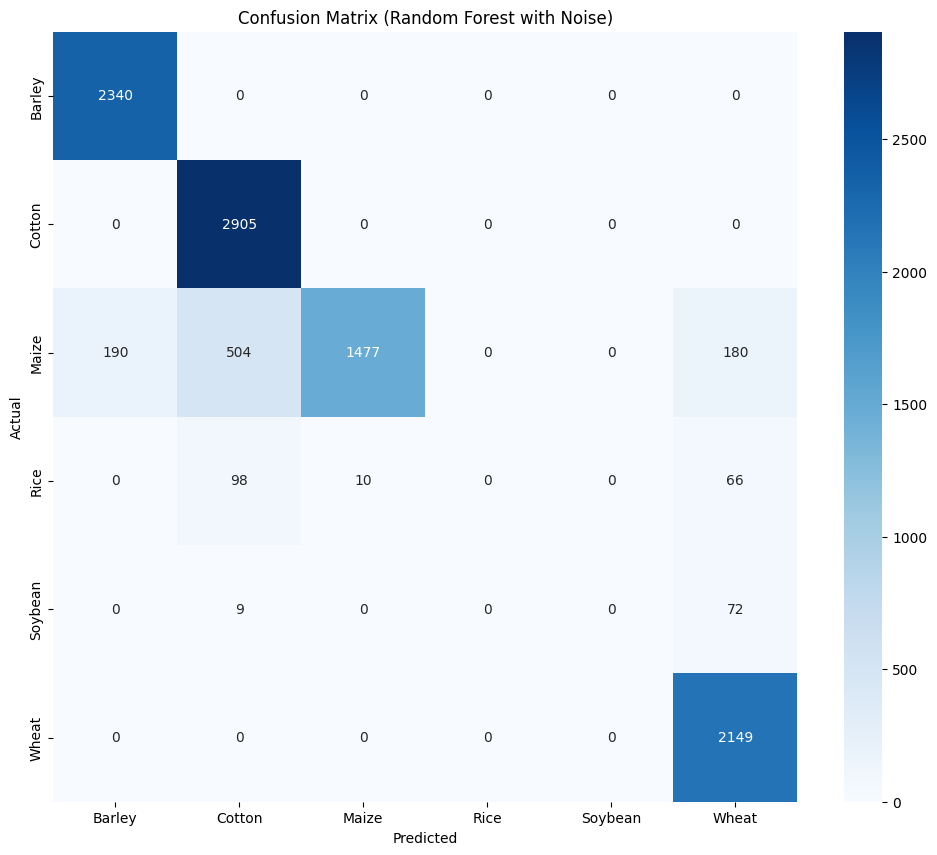

In [ ]:
# Feature importance (Random Forest)
feat_imp = pd.Series(rf.feature_importances_, index=X_train_subset.columns).sort_values(ascending=False)
print("\nTop features influencing crop recommendation:")
print(feat_imp.head(10))

# Confusion matrix for Random Forest
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest with Noise)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Actual Performance Metrics:
SVM: Accuracy=0.9751, Train=1390.97s, Predict=371.4138s
Random Forest: Accuracy=0.8871, Train=0.80s, Predict=0.1174s
Neural Network: Accuracy=0.9947, Train=174.81s, Predict=0.3643s


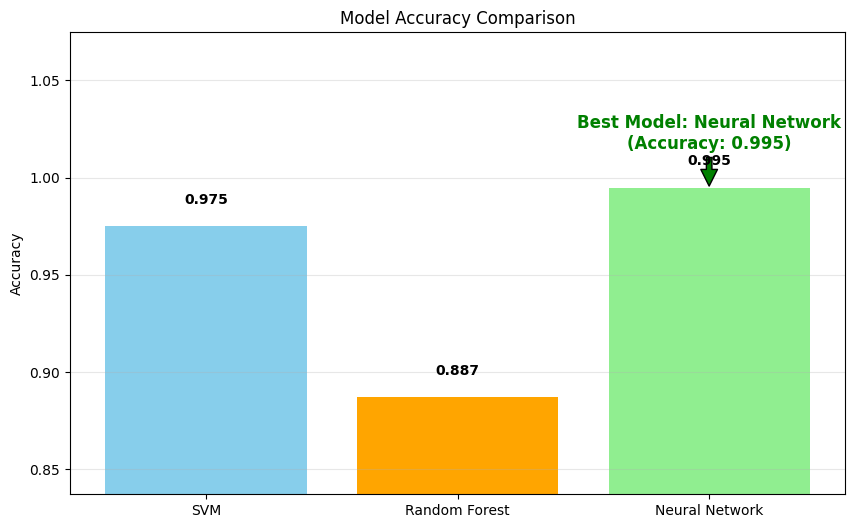

In [ ]:
# Updated performance comparison with actual results
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['SVM', 'Random Forest', 'Neural Network']

# Get actual metrics from the performance measurements
accuracy = [svm_results[2], rf_results[2], mlp_results[2]]
train_latency = [svm_results[0], rf_results[0], mlp_results[0]]
predict_latency = [svm_results[1], rf_results[1], mlp_results[1]]

print(f"\nActual Performance Metrics:")
print(f"SVM: Accuracy={accuracy[0]:.4f}, Train={train_latency[0]:.2f}s, Predict={predict_latency[0]:.4f}s")
print(f"Random Forest: Accuracy={accuracy[1]:.4f}, Train={train_latency[1]:.2f}s, Predict={predict_latency[1]:.4f}s")
print(f"Neural Network: Accuracy={accuracy[2]:.4f}, Train={train_latency[2]:.2f}s, Predict={predict_latency[2]:.4f}s")

# Plot accuracy comparison
plt.figure(figsize=(10,6))
bars = plt.bar(models, accuracy, color=['skyblue', 'orange', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Find and highlight best model
best_idx = accuracy.index(max(accuracy))
best_model = models[best_idx]
plt.annotate(f'Best Model: {best_model}\n(Accuracy: {max(accuracy):.3f})',
             xy=(best_idx, accuracy[best_idx]),
             xytext=(best_idx, accuracy[best_idx]+0.02),
             arrowprops=dict(facecolor='green', shrink=0.05),
             ha='center', color='green', fontsize=12, weight='bold')

# Add value labels on bars
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(min(accuracy)-0.05, max(accuracy)+0.08)
plt.grid(axis='y', alpha=0.3)
plt.show()

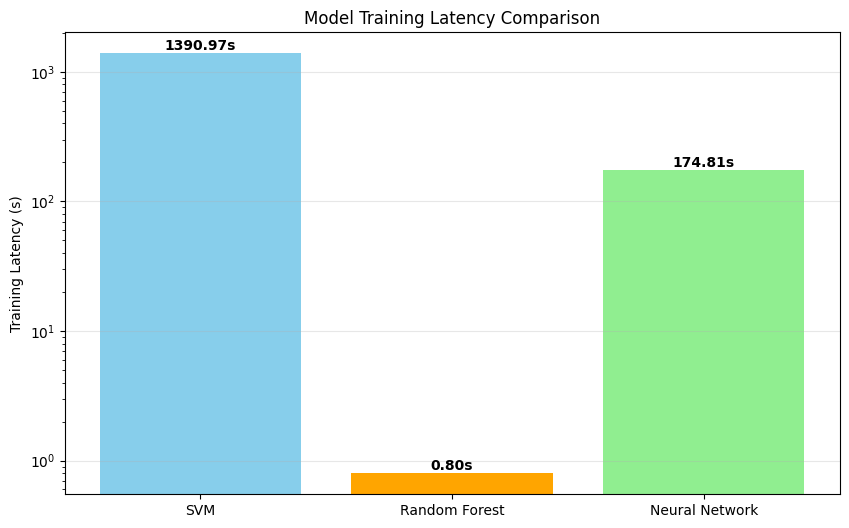

In [ ]:
# Plot training latency
plt.figure(figsize=(10,6))
plt.bar(models, train_latency, color=['skyblue', 'orange', 'lightgreen'])
plt.ylabel('Training Latency (s)')
plt.title('Model Training Latency Comparison')
plt.yscale('log')  # Use log scale for better visualization
for i, v in enumerate(train_latency):
    plt.text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

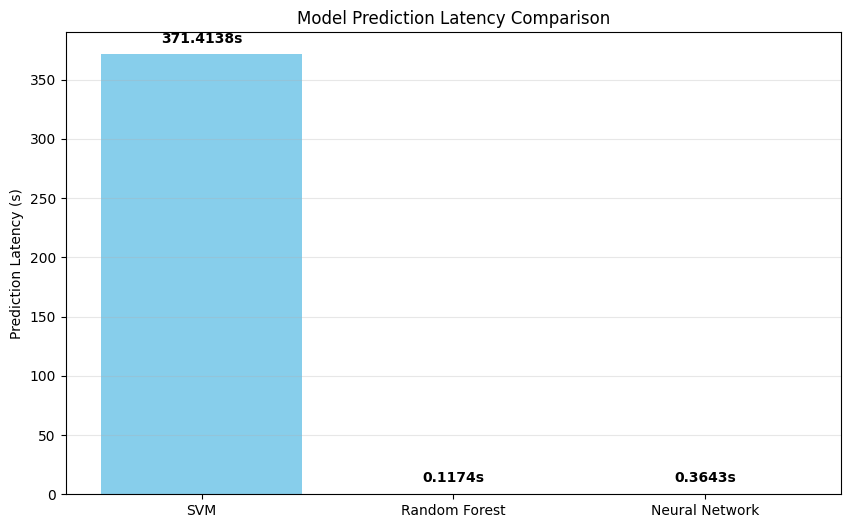

In [ ]:
# Plot prediction latency
plt.figure(figsize=(10,6))
plt.bar(models, predict_latency, color=['skyblue', 'orange', 'lightgreen'])
plt.ylabel('Prediction Latency (s)')
plt.title('Model Prediction Latency Comparison')
for i, v in enumerate(predict_latency):
    plt.text(i, v + max(predict_latency)*0.02, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# Sample predictions
# Select a few random samples from the test set
sample_indices = np.random.choice(X_test.index, size=5, replace=False)
samples = X_test.loc[sample_indices]

# For SVM and Neural Network, scale the samples
samples_scaled = scaler.transform(samples)

# Get true crop names
true_labels = le.inverse_transform(y_test.loc[sample_indices])

# Get predictions
svm_preds = le.inverse_transform(svm.predict(samples_scaled))
rf_preds = le.inverse_transform(rf.predict(samples))
mlp_preds = le.inverse_transform(mlp.predict(samples_scaled))

# Display results in a pretty table
results_df = pd.DataFrame({
    'True Crop': true_labels,
    'SVM Prediction': svm_preds,
    'Random Forest Prediction': rf_preds,
    'Neural Network Prediction': mlp_preds
}, index=sample_indices)

print("\nModel predictions for random test samples:")
print("="*60)
results_df


Model predictions for random test samples:


,True Crop,SVM Prediction,Random Forest Prediction,Neural Network Prediction
12847,Wheat,Wheat,Wheat,Wheat
5891,Wheat,Wheat,Wheat,Wheat
49338,Cotton,Cotton,Cotton,Cotton
6157,Maize,Maize,Cotton,Maize
34583,Cotton,Cotton,Cotton,Cotton
